In [14]:
import sys
%pylab inline
import os
import pandas as pd

import re
import json
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import cvxpy as cp
from scipy import stats


Populating the interactive namespace from numpy and matplotlib


In [15]:
INFINITY = 1e10 # No station value should realistically be higher than this

In [16]:
def objective(x):
    return -np.log(np.diff(x)[::2]).sum()


def clean_solution(solution):
    # Can get an optimal inaccurate solution that doesn't respect the consrtaints.
    # Simple enough to change by forcing y values to be monotonic by raising them
    # Just do a quick check at the end that this "fix" is still a good solution
    y = solution['y']
    z = solution['z']
    c = solution['c']
    clean_y = y.copy()
    sorted_x = c[z]
    for i in range(len(y)):        
        if c[i] == 0:
            clean_y[i] = 0
        elif c[i] == INFINITY:
            clean_y[i] = 1
    for i in range(len(y) - 1):
        if clean_y[z[i+1]] < clean_y[z[i]]:
            clean_y[z[i+1]] = clean_y[z[i]]
    
    if (np.diff(clean_y[z]) < 0).any():
        raise ValueError("Y still not sorted...")
        
    if objective(clean_y) - solution['value'] > 0.1:
        raise ValueError("WARN. Loss of quality!")
    solution['clean_y'] = clean_y

                

In [17]:
def fit(df, partial=False, name=''):
    retval = dict()
    
    n_vars = len(df) * 2
    n_stations = len(df)
    # a is the lower bounds
    a = df['lower_bound_value'] / df['population']
    # b is the upper bounds Make sure that INFINITY isn't different for every station. 
    b = df.apply(lambda row: INFINITY if row['upper_bound_value'] == INFINITY else row['upper_bound_value'] / row['population'], axis=1)
    # Interleave the lower and upper bounds, so the array looks like lb_s, ub_s, lb_s, ub_s...
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    z = np.argsort(c) #z[0] is the smallest value's index
    retval['c'] = c
    retval['z'] = z
    retval['name'] = name
    retval['high_bound'] = np.unique(c[z])[-2]
    if partial:
        return retval
        
    # Encode the problem in cvxpy
    x = cp.Variable(n_vars, nonneg=True)
    # CDF non-decreasing constraint
    constraints = [
        x[z[i]] <= x[z[i+1]] for i in range(n_vars - 1)
    ]
    # Final variable is <= 1. (Note that this will constrain every other variable by the above consrtaints)
    constraints += [x[z[n_vars-1]] <= 1 ]

    # Minimize the NLL
    obj = cp.Minimize(-cp.sum(cp.log(cp.diff(x)[::2])))
    problem = cp.Problem(obj, constraints)
    problem.solve(verbose=True, feastol=1e-12, max_iters=1000)
#     problem.is_dcp()
    print(problem.status)
    if problem.status not in ['infeasible', 'unbounded']:
        print("Optimal value: %s" % problem.value)
    y = problem.variables()[0].value
    retval['y'] = y
    retval['value'] = problem.value
    clean_solution(retval)         
    return retval
    



In [18]:
df = pd.read_csv('UHF_Data_v2.csv')
np.random.seed(1234)
y_all = fit(df, name='all')



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.015e+02  +1e+04  8e-01  4e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -3.526e+01  -2.531e+02  +4e+03  4e-01  3e-01  7e-01  4e-01  0.6674  7e-02   1  1  1 |  0  0
 2  -5.271e+01  -2.207e+02  +2e+03  2e-01  2e-01  6e-01  3e-01  0.4704  3e-01   1  1  1 |  0  1
 3  -7.273e+01  -2.331e+02  +2e+03  2e-01  2e-01  6e-01  2e-01  0.9791  9e-01   1  1  1 | 10  0
 4  -1.257e+02  -2.587e+02  +2e+03  2e-01  2e-01  6e-01  2e-01  0.3789  3e-01   1  1  1 |  3  4
 5  -1.523e+02  -2.600e+02  +1e+03  1e-01  1e-01  6e-01  1e-01  0.9791  7e-01   1  1  1 |  8  0
 6  -2.061e+02  -2.895e+02  +9e+02  9e-02  9e-02  5e-01  9e-02  0.4813  3e-01   1  1  1 |  3  3
 7  -1.818e+02  -2.557e+02  +8e+02  8e-02  7e-02  5e-01  8e-02  0.9791  8e-01   1  1  1 | 10  0
 8  -1.807e+02  -2.491e+02  +7e+02  8e-02  6e-

In [19]:
def interpolater(solution):
    y = solution['clean_y']
    z = solution['z']
    c = solution['c']
    def q(x):
        x_vals = c[z]
        y_vals = y[z]
        return np.interp(x, x_vals, y_vals)
    
    if q(0) != 0:
        raise ValueError("0 is not interpolated right! {q(0)}")
    if np.abs(q(INFINITY) - 1) > 1e-6:
        raise ValueError(f"1 is not interpolated right! {q(INFINITY)}")

    solution['interpolater'] = q


0.10196943638706693 0.11305553760793585
-1.108719844040199 8.698140284166147


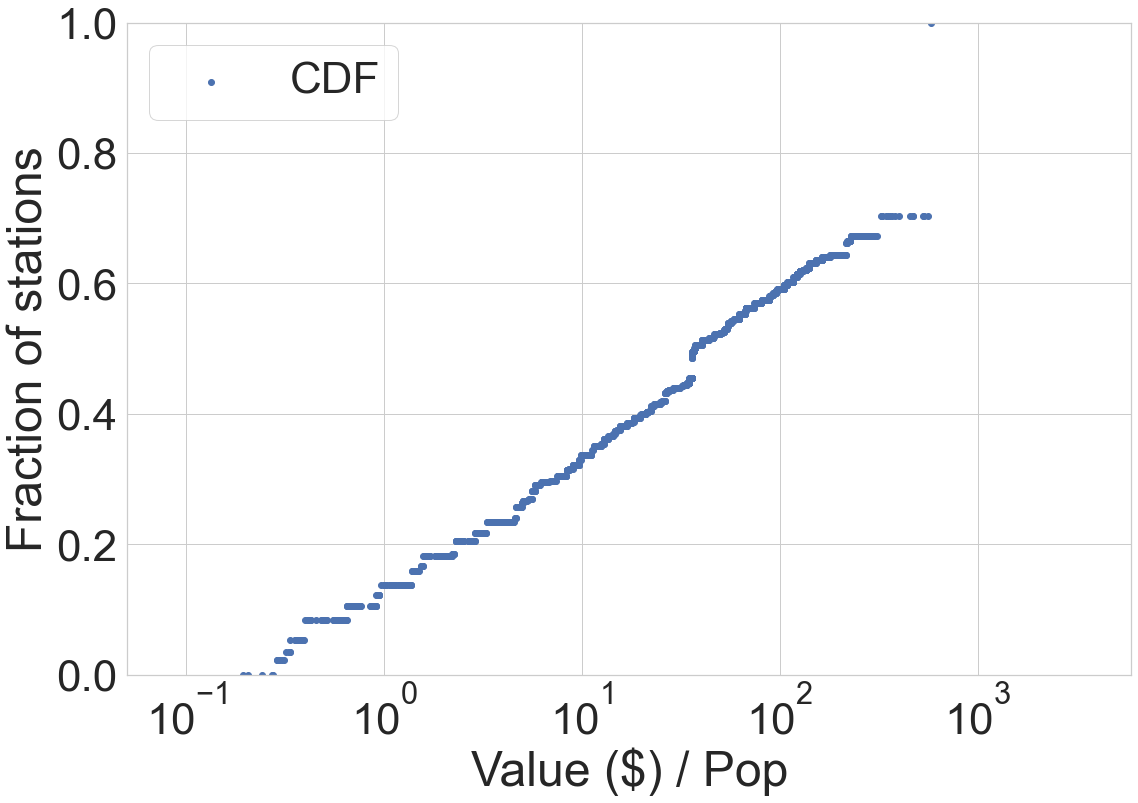

In [20]:
sns.set(font_scale=2)

def derivative_estimate(solution):
    x = np.linspace(0, solution['high_bound'], 100000)
    dx = x[1] - x[0]
    derivative = np.diff(solution['interpolater'](x)) / dx
    return {
        'x': x[1:]-dx/2,
        'y': derivative
    }

def log_uniform_cdf(c, a):
    return lambda x: (np.log(x) - a) / (c-a)

def plot_solution(solution, derivative=False):
    y = solution['clean_y']
    z = solution['z']
    c = solution['c']

    fig = plt.figure(figsize=(18,12))
    sns.set(font_scale=4, style='whitegrid')
    plt.scatter(c, y, label='CDF')
    plt.ylabel('Fraction of stations')
    plt.xlabel('Value ($) / Pop')
    plt.xscale('log')
    plt.xlim(left=1e-1, right=min(solution['high_bound'], 1e5))
    
    idx = np.where((y_all['clean_y'] < 1.) & (y_all['clean_y'] > 0))

    x_data = np.log(y_all['c'][idx])
    y_data = y_all['clean_y'][idx]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    def predict(x):
        return slope * np.log(x) + intercept
    
    print(slope, intercept)
    
    x_data = np.logspace(-1,5,10000)
    
    a = -intercept / slope
    c = (1 - intercept) / slope
    
    print(a, c)
    
    x_data = np.logspace(a,c,10000)
    
    plt.xlim(left=0.05, right=np.exp(c))
    plt.ylim(bottom=0,top=1)
    
    def pdf_func(x):
        return 1 / (x * (c - a))
        
    
    plt.legend(loc='upper left')
    special_save_fig(fig, 'cdf.pdf')

plot_solution(y_all)

(0.0001, 19.473475107429632)

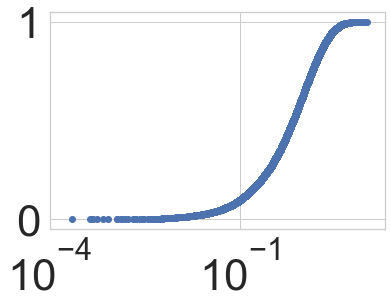

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(np.random.exponential(1, size=10000))
plt.scatter(ecdf.x, ecdf.y)
plt.xscale('log')
plt.xlim(left=1e-4)